In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D, MaxPooling2D

from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras
from tensorflow.keras.utils import  plot_model
import tensorflow_datasets as tfds

from skimage import color, transform

2024-01-25 11:08:25.491217: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 11:08:25.652412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 11:08:25.652433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 11:08:25.680501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 11:08:25.738685: I tensorflow/core/platform/cpu_feature_guar

In [27]:
def preprocess_data(image, labels):

    image = tf.image.resize(image, [224,224])

    image = tf.image.grayscale_to_rgb(image)

    imamge = image / 255.0 

    return image, labels

In [3]:

# Load the MNIST dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']



2024-01-25 11:08:35.656158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-25 11:08:35.745808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-25 11:08:35.745836: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-25 11:08:35.748904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-25 11:08:35.748932: I external/local_xla/xla/stream_executor

In [4]:
print(mnist_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/kw1018/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


2024-01-25 11:11:14.999373: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


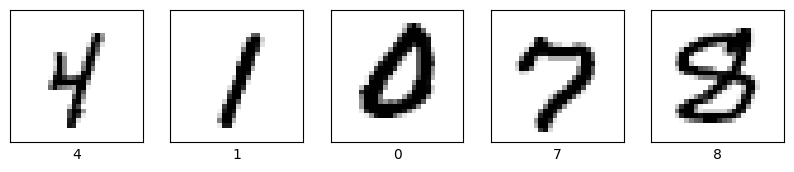

In [6]:
mnist_sample = mnist_train.take(5)

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(mnist_sample):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy().squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label.numpy())
plt.show()


[4, 1, 0, 7, 8]


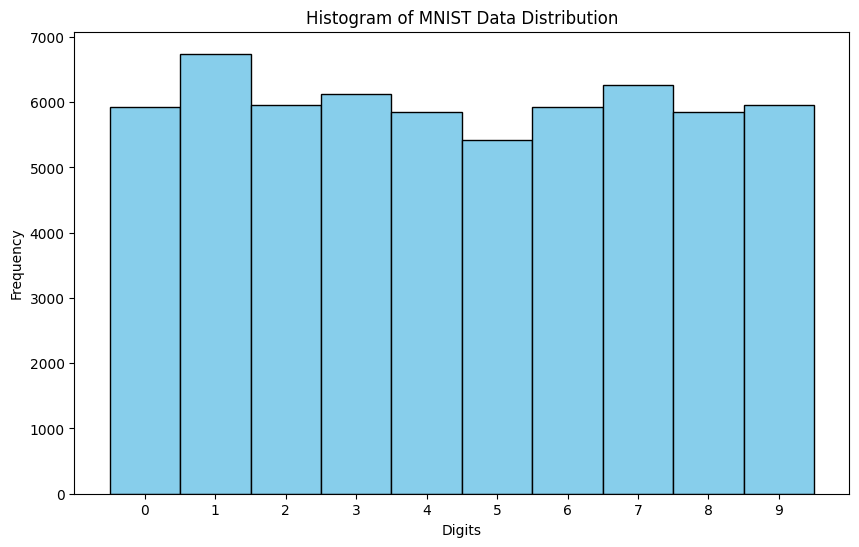

In [21]:
labels_histo = []

for i, (image, label) in enumerate(mnist_train):
    labels_histo.append(label.numpy())


print(labels_histo[:5])

# Set the size of the plot
plt.figure(figsize=(10, 6))  # Width, Height in inches

# Create the histogram
plt.hist(labels_histo, bins=range(11), color='skyblue', edgecolor='black', align='left')

# Add labels and title
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.title('Histogram of MNIST Data Distribution')

# Set the x-axis ticks to explicitly include each digit label
plt.xticks(range(10))  # range(10) creates a list [0, 1, 2, ..., 9]

# Show the plot
plt.show()
    
    

In [25]:
import statistics

#To confirm our findings with out graph!

mnist_mode = statistics.mode(labels_histo)

mnist_mode

1

In [28]:
mnist_train_pre = mnist_train.map(preprocess_data)
mnist_test_pre = mnist_test.map(preprocess_data)

BATCH_SIZE = 32

mnist_train_new = mnist_train_pre.batch(BATCH_SIZE)
mnist_test_new = mnist_test_pre.batch(BATCH_SIZE)

In [34]:
model = Sequential([
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=2, strides=2, padding='valid'),
    Flatten(),
    Dense(164, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

model.fit(mnist_train_new, epochs=10)

Epoch 1/10


2024-01-25 11:35:16.857788: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-01-25 11:35:16.977028: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-25 11:35:17.244297: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-25 11:35:17.322258: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0c6047ad90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-25 11:35:17.322278: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-01-25 11:35:17.329983: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706182517.383619    6014 device_compiler.

1875/1875 [==============================] - 49s 25ms/step - loss: 2.7976 - accuracy: 0.7751
Epoch 2/10
1875/1875 [==============================] - 48s 26ms/step - loss: 0.2567 - accuracy: 0.9381
Epoch 3/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1256 - accuracy: 0.9664
Epoch 4/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0750 - accuracy: 0.9791
Epoch 5/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0503 - accuracy: 0.9850
Epoch 6/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0374 - accuracy: 0.9889
Epoch 7/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0225 - accuracy: 0.9928
Epoch 8/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0185 - accuracy: 0.9942
Epoch 9/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0141 - accuracy: 0.9957
Epoch 10/10
313/313 [==============================] - 2s 7ms/step - loss: 

In [35]:
loss, accuracy = model.evaluate(mnist_test_new)

print(f' accuracy of your model is *drum roll please* oooooooooh! {accuracy * 100}')

313/313 [==============================] - 2s 6ms/step - loss: 0.1789 - accuracy: 0.9728
 accuracy of your model is *drum roll please* oooooooooh! 97.28000164031982
